# 解压数据集

# 飞桨常规赛：PALM眼底彩照视盘探测与分割-8月第8名方案

# （1） 比赛介绍
### 赛题介绍

视网膜由黄斑向鼻侧约3mm处有一直径约1.5mm、境界清楚的淡红色圆盘状结构，称为视神经盘，简称视盘。视盘是眼底图像的一个重要特征，对其进行准确、快速地定位与分割对利用眼底图像进行疾病辅助诊断具有重要意义。


![](https://ai.bdstatic.com/file/94C55072B6204D8BA4983CF94342C4AC)
PALM眼底视盘检测与分割常规赛的重点是研究和发展与患者眼底照片结构分割相关的算法。该常规赛的目标是评估和比较在一个常见的视网膜眼底图像数据集上分割视盘的自动算法。该任务目的是对眼底图像的视盘进行检测，若存在视盘结构，需从眼底图像中分割出视盘区域；若无视盘结构，分割结果直接置全背景。

### 赛程赛制
（1）飞桨常规赛面向全社会公开报名，直至赛题下线；

（2）飞桨常规赛不设初赛、复赛，以当月每位参赛选手提交的最优成绩排名。每月竞赛周期为本月 1 日至本月最后 1 日；

（3）比赛期间选手每天最多可提交 5 次作品（预测结果+原始代码），系统自动选取最高成绩作为榜单记录；

（4）每个月 1-5 日公布上一个月总榜。当月排名前10 且通过代码复查的选手可获得由百度飞桨颁发的荣誉证书。对于初次上榜的参赛选手，还可额外获得1份特别礼包（1个飞桨周边奖品+ 100小时GPU算力卡）。工作人员将以邮件形式通知上一月排名前10的选手提交材料供代码复查，请各位参赛选手留意邮箱通知。特别提醒： 已获得过特别礼包的参赛选手，如果基于本赛题撰写新的studio项目并被评为精选，才可再次获得1份特别礼包；

（5） score超过0.99的第一位选手可额外获得大奖：小度在家；

（6） 鼓励选手报名多个主题的飞桨常规赛，以赛促学，全方面提升开发者的深度学习能力。


### 数据简介
PALM眼底视盘检测与分割常规赛由中山大学中山眼科中心提供800张带病理性近视分类标注的眼底彩照供选手训练模型，另提供400张带标注数据供平台进行模型测试。

### 数据说明
本次常规赛提供的金标准由中山大学中山眼科中心的7名眼科医生手工进行视盘像素级标注，之后由另一位高级专家将它们融合为最终的标注结果。存储为BMP图像，与对应的眼底图像大小相同，标签为0代表视盘（黑色区域）；标签为255代表其他（白色区域）。

### 训练数据集
文件名称：Train
Train文件夹里有fundus_images文件夹和Disc_Masks文件夹。

fundus_images文件夹内包含800张眼底彩照，分辨率为1444×1444，或2124×2056。命名形如H0001.jpg、N0001.jpg、P0001.jpg和V0001.jpg。
Disc_Masks文件夹内包含fundus_images里眼底彩照的视盘分割金标准，大小与对应的眼底彩照一致。命名前缀和对应的fundus_images文件夹里的图像命名一致，后缀为bmp。
### 测试数据集
文件名称：PALM-Testing400-Images
包含400张眼底彩照，命名形如T0001.jpg。


# （2）个人思路

### 自定义数据集


```
class dataset(paddle.io.Dataset):
    def __init__(self,img_list,label_list,mode='train'):

        self.image=img_list
        self.label=label_list
        self.mode=mode
    def load_img(self, image_path,name):
        if name=='img':
            img=cv2.imread(image_path,1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        elif name=='label':
            img=cv2.imread(image_path,1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)            
        return img

    def __getitem__(self,index):
        img = self.load_img(self.image[index],'img')
        label = self.load_img(self.label[index],'label')

        if self.mode=='train':
            img=train_transform(img)
            label=label_transform(label)
        else:
            img=val_transform(img)
            label=label_transform(label)

      

        label=np.squeeze(label)
        label=paddle.unsqueeze(label,axis=0)
        label = np.array(label, dtype='int64')
        return img,label

        
    def __len__(self):
        return len(self.image)
```

### 数据增强

```
import paddle.vision.transforms as T
train_transform=T.Compose([
                        T.Resize(size=[512,512]),                       
                        T.ColorJitter(0.1, 0.1, 0.1, 0.1),

                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),
                        T.ToTensor(),
                        ])
val_transform=T.Compose([
                        T.Resize(size=[512,512]),
                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),
                        T.ToTensor(),
                        ])
label_transform=T.Compose([
                        T.Resize(size=[512,512]),

                        T.Normalize(mean=[0],std=[255],data_format='HWC'),
                        T.ToTensor(),
                        ])
```

### 使用 cosine annealing 的策略来动态调整学习率
```
lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=1e-4,
                                                T_max=step_each_epoch * EPOCHS)
```
### 使用U型网络结构
U-Net是一个U型网络结构，可以看做两个大的阶段，图像先经过Encoder编码器进行下采样得到高级语义特征图，再经过Decoder解码器上采样将特征图恢复到原图片的分辨率。

In [ ]:
!unzip -oq /home/aistudio/data/data102827/常规赛：PALM眼底彩照视盘探测与分割.zip

In [ ]:
!rm -fr __MACOSX

# （3）具体方案分享

## 3.1 自定义数据集

In [1]:
import io
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import paddle

In [2]:

train_path='常规赛：PALM眼底彩照视盘探测与分割/Train/fundus_image/' 
train_label_path='常规赛：PALM眼底彩照视盘探测与分割/Train/Disc_Masks/'
train_list = os.listdir(train_path)
images=[]
labels=[]
label_list=[]
image_list=[]
for i in range(len(train_list)):
    images.append(train_path+train_list[i])
    labels.append(train_label_path+train_list[i][:-3]+'bmp')
    image_list.append(train_path+train_list[i])
    label_list.append(train_label_path+train_list[i][:-3]+'bmp')

In [3]:
test_path='常规赛：PALM眼底彩照视盘探测与分割/PALM-Testing400-Images/'
test_list = os.listdir(test_path)
test_images=[]
test_label=[]
test_size=[]
for i in range(len(test_list)):
    test_images.append(test_path+test_list[i])
    test_label.append(train_label_path+train_list[0][:-3]+'bmp')
    img=cv2.imread(test_path+test_list[i])
    test_size.append(img.shape)



In [4]:
test_size=np.array(test_size)

In [5]:
def write_file(mode, images, labels):
    with open('./{}.txt'.format(mode), 'w') as f:
        for i in range(len(images)):
            f.write('{}\t{}\n'.format(images[i], labels[i]))

In [ ]:

eval_num = int(len(images) * 0.15)
write_file('train', images[:-eval_num], labels[:-eval_num])
write_file('test', images[-eval_num:], labels[-eval_num:])
write_file('predict', images[-eval_num:], labels[-eval_num:])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

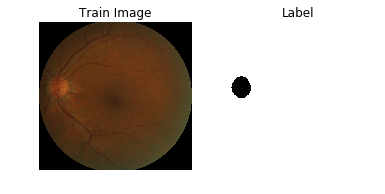

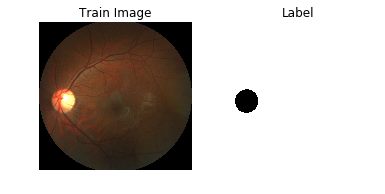

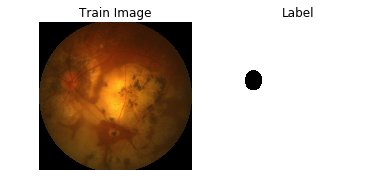

In [ ]:
from PIL import Image as PilImage
import numpy as np
import matplotlib.pyplot as plt
with open('./train.txt', 'r') as f:
    i = 0

    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        image = np.array(PilImage.open(image_path))
        label = np.array(PilImage.open(label_path))
    
        if i > 2:
            break
        # 进行图片的展示
        plt.figure()

        plt.subplot(1,2,1), 
        plt.title('Train Image')
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

        plt.subplot(1,2,2), 
        plt.title('Label')
        plt.imshow(label.astype('uint8'), cmap='gray')
        plt.axis('off')

        plt.show()
        i = i + 1

In [5]:
import paddle.vision.transforms as T
train_transform=T.Compose([
                        T.Resize(size=[512,512]),                       
                        T.ColorJitter(0.1, 0.1, 0.1, 0.1),

                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),
                        T.ToTensor(),
                        ])
val_transform=T.Compose([
                        T.Resize(size=[512,512]),
                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),
                        T.ToTensor(),
                        ])
label_transform=T.Compose([
                        T.Resize(size=[512,512]),

                        T.Normalize(mean=[0],std=[255],data_format='HWC'),
                        T.ToTensor(),
                        ])

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
img1=cv2.imread(label_list[1],1)
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)



plt.imshow(img1,'gray')
plt.show()


img1=label_transform(img1)

img1=np.squeeze(img1)
print(img1.shape)
img1=img1.transpose([1,2,0])

plt.imshow(img1,'gray')
plt.show()

img2=cv2.imread(image_list[1],1)
img2=cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
img2=train_transform(img2)
img2=img2.transpose([1,2,0])
plt.imshow(img2)
plt.show()


##img3=cv2.addWeighted(img4,0.1,img2,0.9,0)
#plt.imshow(img3)
#plt.show()

In [7]:
import paddle

import numpy as np
class dataset(paddle.io.Dataset):
    def __init__(self,img_list,label_list,mode='train'):

        self.image=img_list
        self.label=label_list
        self.mode=mode
    def load_img(self, image_path,name):
        if name=='img':
            img=cv2.imread(image_path,1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        elif name=='label':
            img=cv2.imread(image_path,1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)            
        return img

    def __getitem__(self,index):
        img = self.load_img(self.image[index],'img')
        label = self.load_img(self.label[index],'label')

        if self.mode=='train':
            img=train_transform(img)
            label=label_transform(label)
        else:
            img=val_transform(img)
            label=label_transform(label)

      

        label=np.squeeze(label)
        label=paddle.unsqueeze(label,axis=0)
        label = np.array(label, dtype='int64')
        return img,label

        
    def __len__(self):
        return len(self.image)

In [ ]:
import random

from paddle.io import Dataset
from paddle.vision.transforms import transforms as T


class PetDataset(Dataset):
    """
    数据集定义
    """
    def __init__(self, mode='train'):
        """
        构造函数
        """
        self.image_size = IMAGE_SIZE
        self.mode = mode.lower()
        
        assert self.mode in ['train', 'test', 'predict'], \
            "mode should be 'train' or 'test' or 'predict', but got {}".format(self.mode)
        
        self.train_images = []
        self.label_images = []

        with open('./{}.txt'.format(self.mode), 'r') as f:
            for line in f.readlines():
                image, label = line.strip().split('\t')
                self.train_images.append(image)
                self.label_images.append(label)
        
    def _load_img(self, path, color_mode='rgb', transforms=[]):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')
            
            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        train_image = self._load_img(self.train_images[idx], 
                                     transforms=[
                                         T.Transpose(), 
                                         T.Normalize(mean=127.5, std=127.5)
                                     ]) # 加载原始图像
        label_image = self._load_img(self.label_images[idx], 
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()]) # 加载Label图像
    
        # 返回image, label
        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')
        return train_image, label_image
        
    def __len__(self):
        """
        返回数据集总数
        """
        return len(self.train_images)

## 3.2 模型组网

U-Net是一个U型网络结构，可以看做两个大的阶段，图像先经过Encoder编码器进行下采样得到高级语义特征图，再经过Decoder解码器上采样将特征图恢复到原图片的分辨率。

### 3.2.1 定义SeparableConv2D接口

为了减少卷积操作中的训练参数来提升性能，是继承paddle.nn.Layer自定义了一个SeparableConv2D Layer类，整个过程是把filter_size * filter_size * num_filters的Conv2D操作拆解为两个子Conv2D，先对输入数据的每个通道使用filter_size * filter_size * 1的卷积核进行计算，输入输出通道数目相同，之后在使用1 * 1 * num_filters的卷积核计算。

In [8]:
from paddle.nn import functional as F
import paddle
class SeparableConv2D(paddle.nn.Layer):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride=1, 
                 padding=0, 
                 dilation=1, 
                 groups=None, 
                 weight_attr=None, 
                 bias_attr=None, 
                 data_format="NCHW"):
        super(SeparableConv2D, self).__init__()

        self._padding = padding
        self._stride = stride
        self._dilation = dilation
        self._in_channels = in_channels
        self._data_format = data_format

        # 第一次卷积参数，没有偏置参数
        filter_shape = [in_channels, 1] + self.convert_to_list(kernel_size, 2, 'kernel_size')
        self.weight_conv = self.create_parameter(shape=filter_shape, attr=weight_attr)

        # 第二次卷积参数
        filter_shape = [out_channels, in_channels] + self.convert_to_list(1, 2, 'kernel_size')
        self.weight_pointwise = self.create_parameter(shape=filter_shape, attr=weight_attr)
        self.bias_pointwise = self.create_parameter(shape=[out_channels], 
                                                    attr=bias_attr, 
                                                    is_bias=True)
    
    def convert_to_list(self, value, n, name, dtype=np.int):
        if isinstance(value, dtype):
            return [value, ] * n
        else:
            try:
                value_list = list(value)
            except TypeError:
                raise ValueError("The " + name +
                                "'s type must be list or tuple. Received: " + str(
                                    value))
            if len(value_list) != n:
                raise ValueError("The " + name + "'s length must be " + str(n) +
                                ". Received: " + str(value))
            for single_value in value_list:
                try:
                    dtype(single_value)
                except (ValueError, TypeError):
                    raise ValueError(
                        "The " + name + "'s type must be a list or tuple of " + str(
                            n) + " " + str(dtype) + " . Received: " + str(
                                value) + " "
                        "including element " + str(single_value) + " of type" + " "
                        + str(type(single_value)))
            return value_list
    
    def forward(self, inputs):
        conv_out = F.conv2d(inputs, 
                            self.weight_conv, 
                            padding=self._padding,
                            stride=self._stride,
                            dilation=self._dilation,
                            groups=self._in_channels,
                            data_format=self._data_format)
        
        out = F.conv2d(conv_out,
                       self.weight_pointwise,
                       bias=self.bias_pointwise,
                       padding=0,
                       stride=1,
                       dilation=1,
                       groups=1,
                       data_format=self._data_format)

        return out

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### 3.2.2 定义Encoder编码器

将网络结构中的Encoder下采样过程进行了一个Layer封装，方便后续调用，减少代码编写，下采样是有一个模型逐渐向下画曲线的一个过程，这个过程中是不断的重复一个单元结构将通道数不断增加，形状不断缩小，并且引入残差网络结构，将这些都抽象出来进行统一封装。

In [9]:
class Encoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        
        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.separable_conv_01 = SeparableConv2D(in_channels, 
                                                 out_channels, 
                                                 kernel_size=3, 
                                                 padding='same')
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)])
        
        self.separable_conv_02 = SeparableConv2D(out_channels, 
                                                 out_channels, 
                                                 kernel_size=3, 
                                                 padding='same')
        self.pool = paddle.nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.residual_conv = paddle.nn.Conv2D(in_channels, 
                                              out_channels, 
                                              kernel_size=1, 
                                              stride=2, 
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs
        
        y = self.relus[0](inputs)
        y = self.separable_conv_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.separable_conv_02(y)
        y = self.bns[1](y)
        y = self.pool(y)
        
        residual = self.residual_conv(previous_block_activation)
        y = paddle.add(y, residual)

        return y

### 3.3.3 定义Decoder解码器

在通道数达到最大得到高级语义特征图后，网络结构会开始进行decode操作，进行上采样，通道数逐渐减小，对应图片尺寸逐步增加，直至恢复到原图像大小，那么这个过程里面也是通过不断的重复相同结构的残差网络完成，也是为了减少代码编写，将这个过程定义一个Layer来放到模型组网中使用。

In [10]:
class Decoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.conv_transpose_01 = paddle.nn.Conv2DTranspose(in_channels, 
                                                           out_channels, 
                                                           kernel_size=3, 
                                                           padding=1)
        self.conv_transpose_02 = paddle.nn.Conv2DTranspose(out_channels, 
                                                           out_channels, 
                                                           kernel_size=3, 
                                                           padding=1)
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)]
        )
        self.upsamples = paddle.nn.LayerList(
            [paddle.nn.Upsample(scale_factor=2.0) for i in range(2)]
        )
        self.residual_conv = paddle.nn.Conv2D(in_channels, 
                                              out_channels, 
                                              kernel_size=1, 
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.conv_transpose_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.conv_transpose_02(y)
        y = self.bns[1](y)
        y = self.upsamples[0](y)
        
        residual = self.upsamples[1](previous_block_activation)
        residual = self.residual_conv(residual)
        
        y = paddle.add(y, residual)
        
        return y

### 3.3.4 训练模型组网

按照U型网络结构格式进行整体的网络结构搭建，三次下采样，四次上采样。

In [11]:
class PetNet(paddle.nn.Layer):
    def __init__(self, num_classes):
        super(PetNet, self).__init__()

        self.conv_1 = paddle.nn.Conv2D(3, 32, 
                                       kernel_size=3,
                                       stride=2,
                                       padding='same')
        self.bn = paddle.nn.BatchNorm2D(32)
        self.relu = paddle.nn.ReLU()

        in_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        # 根据下采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.encoder_list:
            block = self.add_sublayer('encoder_{}'.format(out_channels),
                                      Encoder(in_channels, out_channels))
            self.encoders.append(block)
            in_channels = out_channels

        self.decoders = []

        # 根据上采样个数和配置循环定义子Layer，避免重复写一样的程序
        for out_channels in self.decoder_list:
            block = self.add_sublayer('decoder_{}'.format(out_channels), 
                                      Decoder(in_channels, out_channels))
            self.decoders.append(block)
            in_channels = out_channels

        self.output_conv = paddle.nn.Conv2D(in_channels, 
                                            num_classes, 
                                            kernel_size=3, 
                                            padding='same')
    


    def forward(self, inputs):
        y = self.conv_1(inputs)
        y = self.bn(y)
        y = self.relu(y)
        
        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)
        
        y = self.output_conv(y)

        return y

## 3.4 模型可视化

调用飞桨提供的summary接口对组建好的模型进行可视化，方便进行模型结构和参数信息的查看和确认。

In [12]:
IMAGE_SIZE = (512, 512)
num_classes =4
network = PetNet(num_classes)
model = paddle.Model(network)
model.summary((-1, 3,) + IMAGE_SIZE)

-----------------------------------------------------------------------------
  Layer (type)        Input Shape          Output Shape         Param #    
    Conv2D-1       [[1, 3, 512, 512]]   [1, 32, 256, 256]         896      
  BatchNorm2D-1   [[1, 32, 256, 256]]   [1, 32, 256, 256]         128      
     ReLU-1       [[1, 32, 256, 256]]   [1, 32, 256, 256]          0       
     ReLU-2       [[1, 32, 256, 256]]   [1, 32, 256, 256]          0       
SeparableConv2D-1 [[1, 32, 256, 256]]   [1, 64, 256, 256]        2,400     
  BatchNorm2D-2   [[1, 64, 256, 256]]   [1, 64, 256, 256]         256      
     ReLU-3       [[1, 64, 256, 256]]   [1, 64, 256, 256]          0       
SeparableConv2D-2 [[1, 64, 256, 256]]   [1, 64, 256, 256]        4,736     
  BatchNorm2D-3   [[1, 64, 256, 256]]   [1, 64, 256, 256]         256      
   MaxPool2D-1    [[1, 64, 256, 256]]   [1, 64, 128, 128]          0       
    Conv2D-2      [[1, 32, 256, 256]]   [1, 64, 128, 128]        2,112     
    Encode

{'total_params': 2059268, 'trainable_params': 2051716}

## 3.5 模型训练

### 启动模型训练

使用模型代码进行Model实例生成，使用prepare接口定义优化器、损失函数和评价指标等信息，用于后续训练使用。在所有初步配置完成后，调用fit接口开启训练执行过程，调用fit时只需要将前面定义好的训练数据集、测试数据集、训练轮次（Epoch）和批次大小（batch_size）配置好即可。

In [13]:
radio=0.9

train_ds =dataset(image_list[:int(len(image_list)*radio)],label_list[:int(len(label_list)*radio)],'train')
val_ds=dataset(image_list[int(len(image_list)*radio):],label_list[int(len(label_list)*radio):],'valid')

train_loader = paddle.io.DataLoader(train_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=True, num_workers=0)
val_loader = paddle.io.DataLoader(val_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=False, num_workers=0)
#test_dataset=dataset(test_list,test_label,'test')

In [14]:
test_ds =dataset(test_images,test_label,'test')
test_loader = paddle.io.DataLoader(test_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=False, num_workers=0)

aaaaaaaaaaaaaaaaaaa
(1, 512, 512)
[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]


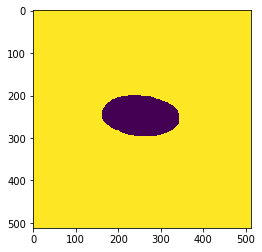

In [16]:
for id,data in enumerate(train_ds):
    print('aaaaaaaaaaaaaaaaaaa')
    img,lb=data

    print(lb.shape)
    print(lb)
    lb=lb.reshape(512,512)
    plt.imshow(lb)
    break

In [ ]:
train_ds = PetDataset(mode='train') # 训练数据集
val_ds = PetDataset(mode='test') # 验证数据集

In [18]:
network = PetNet(num_classes)
model = paddle.Model(network)
#model.load('/home/aistudio/work/lup/final')

Batch_size=32
EPOCHS=15
step_each_epoch = len(train_ds)//Batch_size


lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=1e-4,
                                                T_max=step_each_epoch * EPOCHS)

# 定义Adam优化器
optimizer = paddle.optimizer.Adam(learning_rate=lr,
                                weight_decay=1e-5,
                                parameters=model.parameters())

model.prepare(optimizer, paddle.nn.CrossEntropyLoss(axis=1))


model.fit(train_loader, 
          val_loader, 
          epochs=EPOCHS, 
          batch_size=Batch_size,
          save_dir="/home/aistudio/work/lup", #把模型参数、优化器参数保存至自定义的文件夹
          save_freq=1,                    #设定每隔多少个epoch保存模型参数及优化器参数          
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/15


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 23/23 [==============================] - loss: 0.3865 - 3s/step         
save checkpoint at /home/aistudio/work/lup/0
Eval begin...
step 3/3 [==============================] - loss: 0.1588 - 3s/step
Eval samples: 80
Epoch 2/15
step 23/23 [==============================] - loss: 0.1825 - 3s/step        
save checkpoint at /home/aistudio/work/lup/1
Eval begin...
step 3/3 [==============================] - loss: 0.1759 - 2s/step
Eval samples: 80
Epoch 3/15
step 23/23 [==============================] - loss: 0.1508 - 3s/step        
save checkpoint at /home/aistudio/work/lup/2
Eval begin...
step 3/3 [==============================] - loss: 0.1737 - 2s/step
Eval samples: 80
Epoch 4/15
step 23/23 [==============================] - loss: 0.1683 - 3s/step        
save checkpoint at /home/aistudio/work/lup/3
Eval begin...
step 3/3 [==============================] - loss: 0.1259 - 2s/step
Eval samples: 80
Epoch 5/15
step 23/23 [==============================] - loss: 0.2690 - 3s/step       

# （4）模型预测及结果生成

In [19]:

model.load('/home/aistudio/work/lup/final')
result = model.predict(test_loader)

Predict begin...
step 13/13 [==============================] - 3s/step         
Predict samples: 400


In [20]:
pred=[]
for i in range(len(result[0])):
    pred.extend(result[0][i])

(224, 224, 4)
float32
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


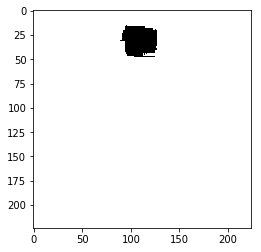

In [38]:
im=pred[2].transpose([1,2,0])
print(im.shape)
print(im.dtype)


mask = np.argmax(im, axis=-1)*255

plt.imshow(mask.astype('uint8'), cmap='gray')
plt.show()
print(mask)




In [ ]:
print(test_size)

[[1444 1444    3]
 [2056 2124    3]
 [2056 2124    3]
 ...
 [2056 2124    3]
 [1444 1444    3]
 [2056 2124    3]]


In [41]:
from paddle.vision.transforms import Resize

result_list = os.listdir('Disc_Segmentation')
for i in range(len(result_list)):
    os.remove('Disc_Segmentation/'+result_list[i])



for i in range(len(pred)):
    
    
    img=pred[i].transpose([1,2,0])
    img=cv2.resize(img,tuple([test_size[i][1],test_size[i][0]]))

    img = np.argmax(img, axis=-1)*255
    #_,img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

 


    cv2.imwrite('/home/aistudio/Disc_Segmentation/'+test_list[i][:-4]+'.png',img)

In [42]:
!zip -r Disc_Segmentation.zip 'Disc_Segmentation' 

# （5）总结+改进完善方向
1、多试几个的预训练模型。

2、选择合适的学习率。

3、更换别的优化器。

# （6）飞桨使用体验+给其他选手学习飞桨的建议
建议大家多参加百度AI Studio课程，多看别人写的AI Studio项目，也许会有灵感迸发，在比赛中取得更好的成绩。

# （7）One More Thing
眼底彩照视盘探测与分割相关论文

1.[Detection of Pathological Myopia and Optic Disc Segmentation with Deep Convolutional Neural Networks](https://ieeexplore.ieee.org/abstract/document/8929252)

2.[Patch-Based Output Space Adversarial Learning for Joint Optic Disc and Cup Segmentation](https://ieeexplore.ieee.org/abstract/document/8643416/)